In the 
[Understanding and Experimenting Capsule Networks](https://fairyonice.github.io/Understanding%20and%20Experimenting%20Capsule%20Networks.html), 
I experimented [Hinton's Capsule Network](https://arxiv.org/abs/1710.09829). 

[Dynamic Routing Between Capsules](https://arxiv.org/abs/1710.09829) discusses the robustness of the Capsule Networks to affine transformations:

_"Experiments show that each DigitCaps capsule learns a more robust representation for each class than a traditional convolutional network. Because there is natural variance in skew, rotation, style, etc in hand written digits, the trained CapsNet is moderately robust to small affine transformations of the training data (Section 5.2, page 6)."_

The authors used [affNIST](http://www.cs.toronto.edu/~tijmen/affNIST) for the robustness valdiation. 

In this  blog, I evaluate the robustness of this network.
I will create affine transformed MNIST test data by myself and use [my version of CapsNet](https://fairyonice.github.io/Understanding%20and%20Experimenting%20Capsule%20Networks.html) and 
[my version of the standard CNN model](https://fairyonice.github.io/CNN%20modeling%20with%20image%20translations%20using%20MNIST%20data.html) introduced in prvious blog posts for predicting the correct class of digits in this new data.
[my version of CapsNet](https://fairyonice.github.io/Understanding%20and%20Experimenting%20Capsule%20Networks.html) and 
[my version of the standard CNN model](https://fairyonice.github.io/CNN%20modeling%20with%20image%20translations%20using%20MNIST%20data.html) respectively yield validation losses of 0.42% and 0.50% on MNIST with no affine transformation.
As the models are trained only on 2-pixel shifted MNIST, the performance of models would deteriorate.
Nevertheless, I expect that robust model would have lower performance deterioration. 



## Reference 
- [Dynamic Routing Between Capsules](https://arxiv.org/abs/1710.09829)
- [Understanding and Experimenting Capsule Networks](https://fairyonice.github.io/Understanding%20and%20Experimenting%20Capsule%20Networks.html)

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
import keras
import sys
print("python {}".format(sys.version))
print("keras version {}".format(keras.__version__))
print("tensorflow version {}".format(tf.__version__))
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.95
config.gpu_options.visible_device_list = "2"
#### 2 GPU1
#### 0 GPU3
#### 4 GPU4
#### 3 GPU2
set_session(tf.Session(config=config))

Using TensorFlow backend.


python 2.7.13 |Anaconda 4.3.1 (64-bit)| (default, Dec 20 2016, 23:09:15) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
keras version 2.0.6
tensorflow version 1.2.1


## Define class objects for CapsNet.
The codes here are created by modifing [Kevin Mader's ipython notebook script in Kaggle competition](https://www.kaggle.com/kmader/capsulenet-on-mnist), which, in turn are written by adapting [Xifeng Guo's script in Github](https://github.com/XifengGuo/CapsNet-Keras/blob/master/capsulenet.py).

In [2]:
import keras.backend as K
from keras import initializers, layers
from keras import models

class Length(layers.Layer):
    """
    Compute the length of vectors. This is used to compute a Tensor that has the same shape with y_true in margin_loss
    inputs: shape=[dim_1, ..., dim_{n-1}, dim_n]
    output: shape=[dim_1, ..., dim_{n-1}]
    """
    def call(self, inputs, **kwargs):
        return K.sqrt(K.sum(K.square(inputs), -1))

    def compute_output_shape(self, input_shape):
        return input_shape[:-1]

class Mask(layers.Layer):
    """
    Mask a Tensor with shape=[None, d1, d2] by the max value in axis=1.
    Output shape: [None, d2]
    
    This class is used to reduce the dimention of the 
    
    (Nsample, n_class, dim_vector) --> (Nsample, dim_vector)
    For training:
        only keep the activity vector (v in paper) of true class 
    for testing
        only keep the activity vector with the largest norm (length in vector)
    """
    def call(self, inputs, **kwargs):
        # use true label to select target capsule, shape=[batch_size, num_capsule]
        if type(inputs) is list:  # true label is provided with shape = [batch_size, n_classes], i.e. one-hot code.
            assert len(inputs) == 2
            inputs, mask = inputs
        else:  # if no true label, mask by the max length of vectors of capsules
            x = inputs
            # Enlarge the range of values in x to make max(new_x)=1 and others < 0
            x = (x - K.max(x, 1, True)) / K.epsilon() + 1
            mask = K.clip(x, 0, 1)  # the max value in x clipped to 1 and other to 0

        # masked inputs, shape = [batch_size, dim_vector]
        inputs_masked = K.batch_dot(inputs, mask, [1, 1])
        return inputs_masked

    def compute_output_shape(self, input_shape):
        if type(input_shape[0]) is tuple:  # true label provided
            return tuple([None, input_shape[0][-1]])
        else:
            return tuple([None, input_shape[-1]])


def squash(vectors, axis=-1):
    """
    The non-linear activation used in Capsule. It drives the length of a large vector to near 1 and small vector to 0
    :param vectors: some vectors to be squashed, N-dim tensor
    :param axis: the axis to squash
    :return: a Tensor with same shape as input vectors
    """
    s_squared_norm = K.sum(K.square(vectors), axis, keepdims=True)
    scale = s_squared_norm / (1 + s_squared_norm) / K.sqrt(s_squared_norm)
    return scale * vectors


class CapsuleLayer(layers.Layer):
    """
    The capsule layer. It is similar to Dense layer. Dense layer has `in_num` inputs, each is a scalar, the output of the 
    neuron from the former layer, and it has `out_num` output neurons. CapsuleLayer just expand the output of the neuron
    from scalar to vector. So its input shape = [None, input_num_capsule, input_dim_vector] and output shape = \
    [None, num_capsule, dim_vector]. For Dense Layer, input_dim_vector = dim_vector = 1.
    
    :param num_capsule: number of capsules in this layer
    :param dim_vector: dimension of the output vectors of the capsules in this layer
    :param num_routings: number of iterations for the routing algorithm
    """
    def __init__(self, num_capsule, dim_vector, num_routing=3,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_vector = dim_vector
        self.num_routing = num_routing
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)

    def build(self, input_shape):
        assert len(input_shape) >= 3, "The input Tensor should have shape=[None, input_num_capsule, input_dim_vector]"
        self.input_num_capsule = input_shape[1]
        self.input_dim_vector = input_shape[2]

        # Transform matrix
        self.W = self.add_weight(shape=[self.input_num_capsule, self.num_capsule, self.input_dim_vector, self.dim_vector],
                                 initializer=self.kernel_initializer,
                                 name='W')

        # Coupling coefficient. The redundant dimensions are just to facilitate subsequent matrix calculation.
        self.bias = self.add_weight(shape=[1, self.input_num_capsule, self.num_capsule, 1, 1],
                                    initializer=self.bias_initializer,
                                    name='bias',
                                    trainable=False)
        self.built = True

    def call(self, inputs, training=None):
        # inputs.shape=[None, input_num_capsule, input_dim_vector]
        # Expand dims to [None, input_num_capsule, 1, 1, input_dim_vector]
        inputs_expand = K.expand_dims(K.expand_dims(inputs, 2), 2)

        # Replicate num_capsule dimension to prepare being multiplied by W
        # Now it has shape = [None, input_num_capsule, num_capsule, 1, input_dim_vector]
        inputs_tiled = K.tile(inputs_expand, [1, 1, self.num_capsule, 1, 1])

        """  
        # Compute `inputs * W` by expanding the first dim of W. More time-consuming and need batch_size.
        # Now W has shape  = [batch_size, input_num_capsule, num_capsule, input_dim_vector, dim_vector]
        w_tiled = K.tile(K.expand_dims(self.W, 0), [self.batch_size, 1, 1, 1, 1])
        
        # Transformed vectors, inputs_hat.shape = [None, input_num_capsule, num_capsule, 1, dim_vector]
        inputs_hat = K.batch_dot(inputs_tiled, w_tiled, [4, 3])
        """
        # Compute `inputs * W` by scanning inputs_tiled on dimension 0. This is faster but requires Tensorflow.
        # inputs_hat.shape = [None, input_num_capsule, num_capsule, 1, dim_vector]
        inputs_hat = tf.scan(lambda ac, x: K.batch_dot(x, self.W, [3, 2]),
                             elems=inputs_tiled,
                             initializer=K.zeros([self.input_num_capsule, self.num_capsule, 1, self.dim_vector]))
        """
        # Routing algorithm V1. Use tf.while_loop in a dynamic way.
        def body(i, b, outputs):
            c = tf.nn.softmax(self.bias, dim=2)  # dim=2 is the num_capsule dimension
            outputs = squash(K.sum(c * inputs_hat, 1, keepdims=True))
            b = b + K.sum(inputs_hat * outputs, -1, keepdims=True)
            return [i-1, b, outputs]

        cond = lambda i, b, inputs_hat: i > 0
        loop_vars = [K.constant(self.num_routing), self.bias, K.sum(inputs_hat, 1, keepdims=True)]
        _, _, outputs = tf.while_loop(cond, body, loop_vars)
        """
        # Routing algorithm V2. Use iteration. V2 and V1 both work without much difference on performance
        assert self.num_routing > 0, 'The num_routing should be > 0.'
        for i in range(self.num_routing):
            c = tf.nn.softmax(self.bias, dim=2)  # dim=2 is the num_capsule dimension
            # outputs.shape=[None, 1, num_capsule, 1, dim_vector]
            outputs = squash(K.sum(c * inputs_hat, 1, keepdims=True))

            # last iteration needs not compute bias which will not be passed to the graph any more anyway.
            if i != self.num_routing - 1:
                # self.bias = K.update_add(self.bias, K.sum(inputs_hat * outputs, [0, -1], keepdims=True))
                self.bias += K.sum(inputs_hat * outputs, -1, keepdims=True)
            # tf.summary.histogram('BigBee', self.bias)  # for debugging
        return K.reshape(outputs, [-1, self.num_capsule, self.dim_vector])

    def compute_output_shape(self, input_shape):
        return tuple([None, self.num_capsule, self.dim_vector])


def PrimaryCap(inputs, dim_vector, n_channels, kernel_size, strides, padding):
    """
    Apply Conv2D `n_channels` times and concatenate all capsules
    :param inputs: 4D tensor, shape=[None, width, height, channels]
    :param dim_vector: the dim of the output vector of capsule
    :param n_channels: the number of types of capsules
    :return: output tensor, shape=[None, num_capsule, dim_vector]
    """
    output = layers.Conv2D(filters=dim_vector*n_channels, ## 8 x 32
                           kernel_size=kernel_size,       ## 9x9
                           strides=strides,               ## 2   
                           padding=padding,name="PrimaryCap_conv2d")(inputs)
    outputs = layers.Reshape(target_shape=[-1, dim_vector],name="PrimaryCap_reshape")(output)
    return layers.Lambda(squash,name="PrimaryCap_squash")(outputs)

def NetworkInputToDigitCap(input_shape,n_class,num_routing):
    x = layers.Input(shape=input_shape)

    # Layer 1: Just a conventional Conv2D layer
    conv1 = layers.Conv2D(filters=256, kernel_size=9, 
                          strides=1, padding='valid', activation='relu', 
                          name='Conv1')(x)

    # Layer 2: Conv2D layer with `squash` activation, 
    #          then reshape to [None, num_capsule, dim_vector]
    primarycaps = PrimaryCap(conv1, dim_vector=8, 
                             n_channels=32, kernel_size=9, 
                             strides=2, padding='valid')

    # Layer 3: Capsule layer. Routing algorithm works here.
    digitcaps = CapsuleLayer(num_capsule=n_class, 
                             dim_vector=16, num_routing=num_routing, 
                             name='DigitCaps')(primarycaps)
    

    return(x, digitcaps)

## CapsNet functions

In [3]:

from keras import backend as K

def CapsNet(input_shape, n_class, num_routing):
    """
    A Capsule Network on MNIST.
    :param input_shape: data shape, 4d, [None, width, height, channels]
    :param n_class: number of classes
    :param num_routing: number of routing iterations
    :return: A Keras Model with 2 inputs and 2 outputs
    """
    x, digitcaps = NetworkInputToDigitCap(input_shape,n_class, num_routing)
    
    # Layer 4: This is an auxiliary layer to replace each capsule with its length. 
    #          Just to match the true label's shape.
    # If using tensorflow, this will not be necessary. :)
    out_caps = Length(name='out_caps')(digitcaps) ##||v|| margin_loss
    
    # Decoder network.
    y = layers.Input(shape=(n_class,),name="true_label") 
    masked = Mask(name="activity_vec")([digitcaps, ## digitcaps.shape = (Nsample, n_class, dim_vector )
                     y])  # The true label is used to mask the output of capsule layer.
    
    x_recon = Decoder(masked)

    # two-input-two-output keras Model
    m1 = models.Model([x, y], [out_caps, x_recon])
    m2 = models.Model([x],[digitcaps]) ## YUMI added this line
    return m1, m2 



def Decoder(masked):
    ## Yumi refactored
    x_recon = layers.Dense(512, activation='relu',name="FC1")(masked)
    x_recon = layers.Dense(1024, activation='relu',name="FC2")(x_recon)
    x_recon = layers.Dense(784, activation='sigmoid',name="FC3")(x_recon)
    ## mse to ensure that the reconstructed images are close to the original image.
    x_recon = layers.Reshape(target_shape=[28, 28, 1], name='out_recon')(x_recon) 
    return(x_recon)

### Build a CapsNet model and load the weights 

In [4]:
import keras.backend as K
from keras import initializers, layers
from keras import models

CapsNet, model_wo_decoder = CapsNet(
    input_shape=[28, 28, 1],
    n_class=10,
    num_routing=3)

CapsNet.load_weights("CapsNet_weights.h5")

### Build a standard CNN model and load the weights

In [5]:
from keras.models import model_from_json
def load_model(name):
    model = model_from_json(open(name+'_architecture.json').read())
    model.load_weights(name + '_weights.h5')
    return(model)
standard = load_model("standard")

### Use Keras's ImageDataGenerator to modify the original data, and create transforemd data.

In [6]:
from keras.preprocessing.image import ImageDataGenerator
from numpy.random import seed
from tensorflow import set_random_seed

def generate_once(x, y, 
                  shift_fraction=0.1,
                  shear_range=0.2,
                  zoom_range=0.2,
                  rotation_range=40):
    '''
    modify each image in x to generate new data 
    return x, y of the same shape
    
    seed is set for reproducable results
    '''
    seed(1)
    set_random_seed(1)
    batch_size = x.shape[0]
    train_datagen = ImageDataGenerator( width_shift_range=shift_fraction,
                                        height_shift_range=shift_fraction,
                                        shear_range=shear_range,
                                        rotation_range=rotation_range,
                                        zoom_range=zoom_range)  # shift up to 2 pixel for MNIST
    generator = train_datagen.flow(x, y, batch_size=batch_size)
    x, y = generator.next()
    return([x,y])

def plot_example_images(x_tra,title,n = 10):
    '''
    plot first n images in x_tra
    '''
    const = 0.9
    fig = plt.figure(figsize=(n*const,1*const)) 
    fig.subplots_adjust(hspace=0.01,wspace=0.01,
                        left=0,right=1,bottom=0, top=1)
    for i in range(x_tra.shape[0]):    
        ax = fig.add_subplot(1,n,i+1,xticks=[],yticks=[])
        ax.imshow(x_tra[i].reshape(28,28))
        if n < (i + 2):
            break
    plt.suptitle("shift_fraction:{}, shear_range:{}, zoom_range:{}, {}".format(
                 shift_fraction, shear_range, zoom_range,title),y=1.5)
    plt.show()
    
def get_error(y_tra,y_pr):
    '''
    Return error 
    
    y_tr : np.array() of shape (Nsample, Ncat), containing 0 or 1
    y_pr : np.array() of shape (Nsample, Ncat), containing probabilities
    '''
    pred_class = y_pr.argmax(axis=1)
    acc = np.mean(y_tra[range(len(pred_class)),pred_class]==1)*100
    return(100 - acc)

## Load MNIST test data
Here, I only load test data because I will use the test for evaluation only.

In [7]:
from mnist import MNIST
import numpy as np
from keras.utils import to_categorical

mndata = MNIST('./MNIST_data/')

images, labels = mndata.load_testing()

x_test, y_test = np.array(images),np.array(labels)
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255.
y_test = to_categorical(y_test.astype('float32'))

print(x_test.shape,y_test.shape)

((10000, 28, 28, 1), (10000, 10))



The validation error reported in [my previous blog article about CapsNet](https://fairyonice.github.io/Understanding%20and%20Experimenting%20Capsule%20Networks.html) and 
[my previous blog article about standard CNN model blog](https://fairyonice.github.io/CNN%20modeling%20with%20image%20translations%20using%20MNIST%20data.html) are:
    - CapsNet:  0.42%
    - Standard:  0.54%
We reproduce these results first.

In [8]:
y_pred_Cap,_ = CapsNet.predict([x_test,y_test])
y_pred_sta = standard.predict(x_test)

acc_Cap = get_error(y_test,y_pred_Cap)
acc_sta = get_error(y_test,y_pred_sta)

print("Error CapsNet: {:5.3}%, Standard: {:5.3}%".format(
                acc_Cap,acc_sta))


Error CapsNet:  0.42%, Standard:  0.54%


## Model performance assessments with affine transfomation.
I consider four types of affine transfomation:
- shifting
- shearing 
- zooming
- rotation

For rotation, I always consider rotating images for at most 40 degrees.
For other types of affine transfomation, I consider 3 different degree, and created 27 different generated data.

For each generated data, I will classify the digits using the two models.
Let's see which model is more robust to the changes. 

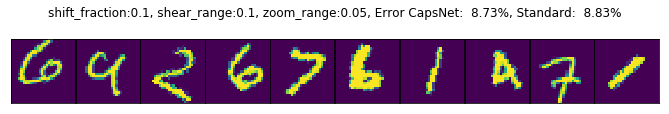

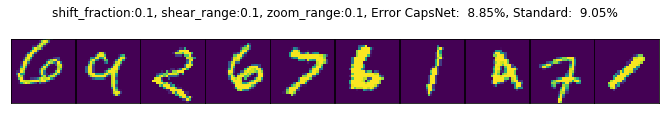

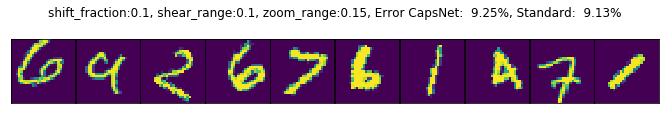

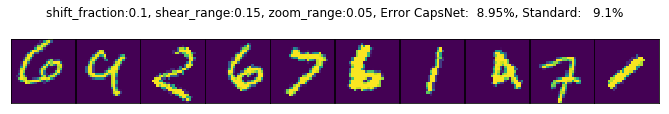

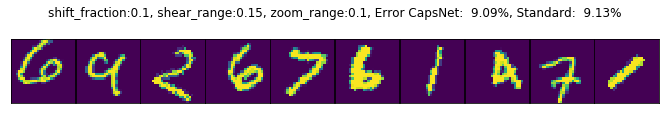

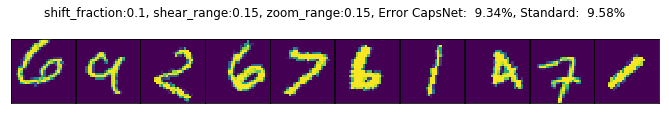

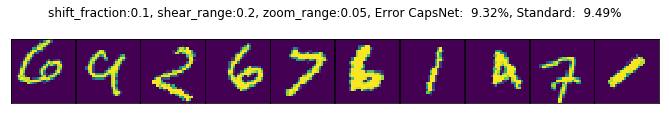

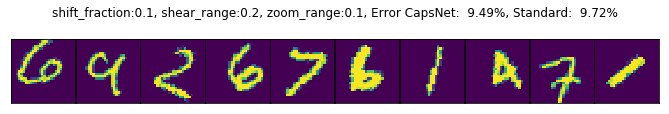

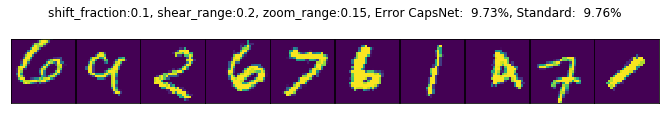

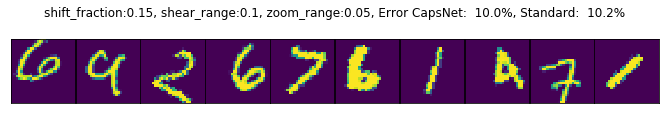

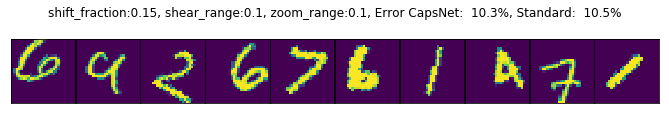

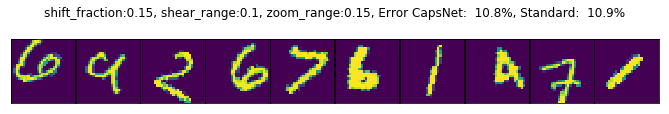

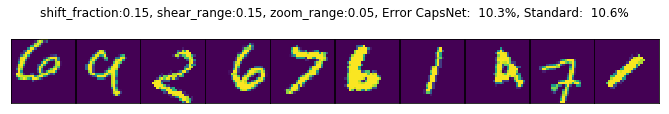

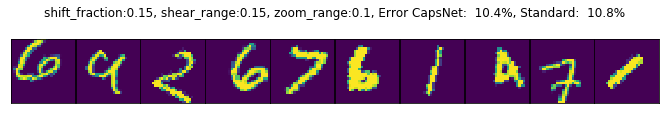

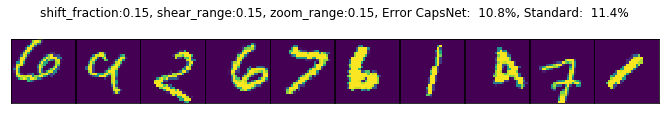

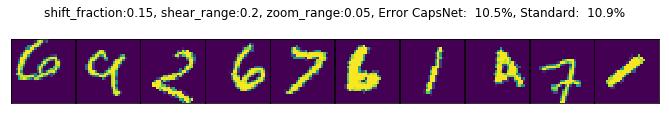

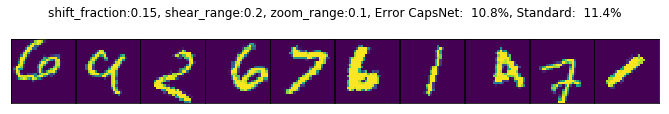

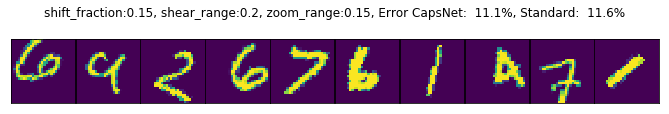

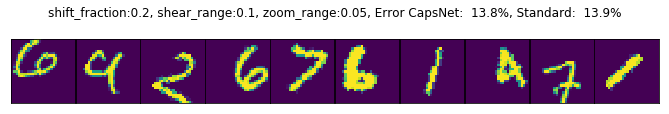

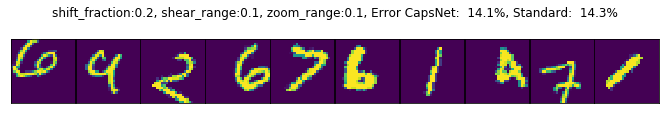

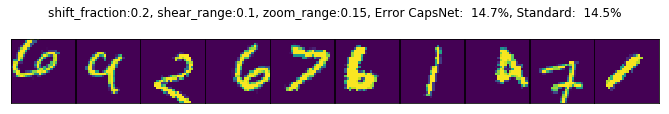

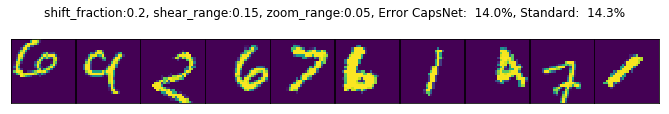

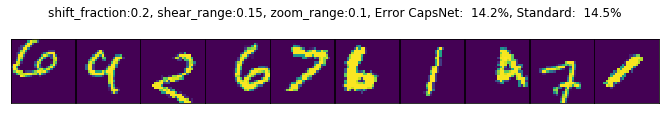

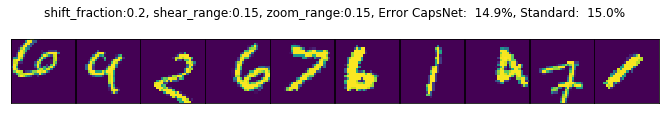

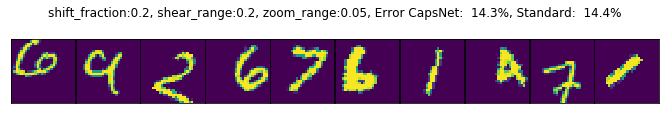

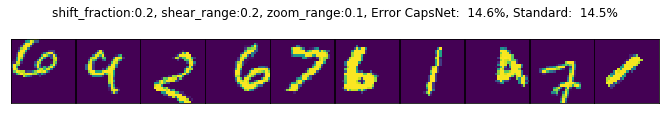

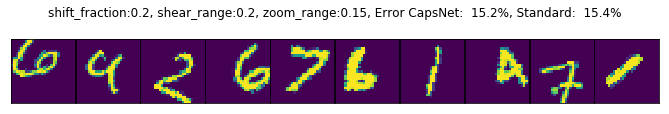

In [9]:
shift_fractions = [ 0.1, 0.15, 0.2]
shear_ranges    = [ 0.1, 0.15, 0.2]
zoom_ranges     = [ 0.05, 0.1, 0.15]
N = len(shift_fractions)

result_Cap = np.zeros((N,N,N))
result_sta = np.zeros((N,N,N))

for ishift, shift_fraction in enumerate(shift_fractions):
    for ishear, shear_range in enumerate(shear_ranges):
        for izoom, zoom_range in enumerate(zoom_ranges):
            x_tra,y_tra = generate_once(
                            x_test, y_test, 
                            shift_fraction,
                            shear_range,
                            zoom_range)
            
            
            ### Prediction by CapsNet and the standard CNN
            y_pred_Cap,_ = CapsNet.predict([x_tra,y_tra])
            y_pred_sta = standard.predict(x_tra)
            ### Prediction error
            acc_Cap = get_error(y_tra,y_pred_Cap)
            acc_sta = get_error(y_tra,y_pred_sta)
            
            result_Cap[ishift, ishear, izoom]= acc_Cap
            result_sta[ishift, ishear, izoom]= acc_sta
            
            title = "Error CapsNet: {:5.3}%, Standard: {:5.3}%".format(
                    acc_Cap,acc_sta)
            plot_example_images(x_tra,title)

## Evaluation results for the two model's prediction performance on various augmented data.

- Both CapsNet and standard CNN deteriorates the performance when more severe transfomation is performed.
- CapsNet does not always yield the smaller error than the standard CNN for considered set of transformed data.
- When zooming proportion is low (<=0.1), CapsNet always performs better than the standard CNN no matter what other affine transfomation is applyed to the data.


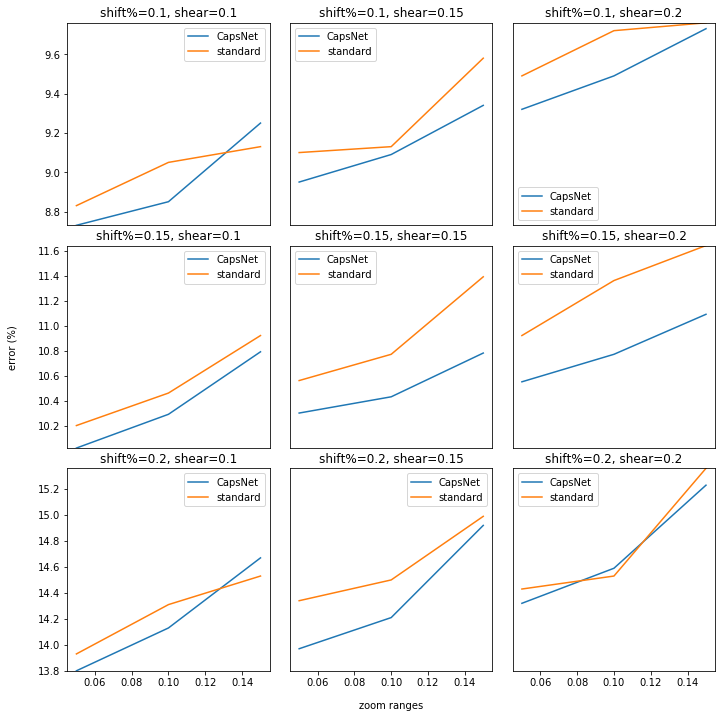

In [10]:
const = 3
N = result_Cap.shape[0]
fig = plt.figure(figsize=(N*const,N*const))
fig.subplots_adjust(hspace=0.1,wspace=0.1,
                    left=0,right=1,bottom=0, top=1)
count = 1
for ishift in range(N):
    for ishear in range(N):
        if  (ishear == 0) and (ishift == N - 1):
            ax = fig.add_subplot(N,N,count)
        elif ishear == 0:
            ax = fig.add_subplot(N,N,count,
                                 xticks=[]
                                 )
        elif ishift == N - 1:
            ax = fig.add_subplot(N,N,count,
                                 yticks=[])
        else:
            ax = fig.add_subplot(N,N,count,
                                 xticks=[],
                                 yticks=[])
        count += 1
        cvec = result_Cap[ishift,ishear,:]
        svec = result_sta[ishift,ishear,:]
        ax.plot(zoom_ranges, cvec, label="CapsNet")
        ax.plot(zoom_ranges, svec, label="standard")
        vec = list(result_Cap[ishift,:,:]) + list(result_sta[ishift,:,:])
        ax.set_ylim(np.min(vec),np.max(vec))
        ax.set_title("shift%={}, shear={}".format(
            shift_fractions[ishift],
            shear_ranges[ishear]))
        ax.legend()
ax = fig.add_subplot(1,1,1,frameon=False,xticks=[],yticks=[])
ax.set_xlabel("zoom ranges",labelpad=30) 
ax.set_ylabel("error (%)",labelpad=50) 
plt.show()